# Initialize

In [13]:
# MFR classification
#
# analyses HELCATS ICMECAT for predicting labels of CME MFRs
# Author: C. Moestl, Space Research Institute IWF Graz, Austria
# last update: May 2018



#2 how to predict the rest of the MFR if first 10, 20, 30, 40, 50% are seen?
#everything should be automatically with a deep learning method or ML fit methods

%matplotlib inline
from scipy import stats
import scipy.io
from matplotlib import cm
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import sunpy.time
import time
import pickle
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

sns.set_context("talk")     
sns.set_style("darkgrid")  

plt.close('all')

######## functions

def getcat(filename):
  print('reading CAT')
  cat=scipy.io.readsav(filename, verbose='true')  
  print('done CAT')
  return cat  
  
def decode_array(bytearrin):
 #for decoding the strings from the IDL .sav file to a list of python strings, not bytes 
 #make list of python lists with arbitrary length
 bytearrout= ['' for x in range(len(bytearrin))]
 for i in range(0,len(bytearrin)-1):
  bytearrout[i]=bytearrin[i].decode()
 #has to be np array so to be used with numpy "where"
 bytearrout=np.array(bytearrout)
 return bytearrout  
  

def time_to_num_cat(time_in):  

  #for time conversion from catalogue .sav to numerical time
  #this for 1-minute data or lower time resolution

  #for all catalogues
  #time_in is the time in format: 2007-11-17T07:20:00 or 2007-11-17T07:20Z
  #for times help see: 
  #http://docs.sunpy.org/en/latest/guide/time.html
  #http://matplotlib.org/examples/pylab_examples/date_demo2.html
  
  j=0
  #time_str=np.empty(np.size(time_in),dtype='S19')
  time_str= ['' for x in range(len(time_in))]
  #=np.chararray(np.size(time_in),itemsize=19)
  time_num=np.zeros(np.size(time_in))
  
  for i in time_in:

   #convert from bytes (output of scipy.readsav) to string
   time_str[j]=time_in[j][0:16].decode()+':00'
   year=int(time_str[j][0:4])
   time_str[j]
   #convert time to sunpy friendly time and to matplotlibdatetime
   #only for valid times so 9999 in year is not converted
   #pdb.set_trace()
   if year < 2100:
    	  time_num[j]=mdates.date2num(sunpy.time.parse_time(time_str[j]))
   j=j+1  
   #the date format in matplotlib is e.g. 735202.67569444
   #this is time in days since 0001-01-01 UTC, plus 1.
   
   #return time_num which is already an array and convert the list of strings to an array
  return time_num, np.array(time_str)


def IDL_time_to_num(time_in):  
 #convert IDL time to matplotlib datetime
 time_num=np.zeros(np.size(time_in))
 for ii in np.arange(0,np.size(time_in)):
   time_num[ii]=mdates.date2num(sunpy.time.parse_time(time_in[ii]))   
 return time_num 
  

def gaussian(x, amp, mu, sig):
     return amp * exp(-(x-cen)**2 /wid)


def dynamic_pressure(density, speed):
   # make dynamic pressure from density and speed
   #assume pdyn is only due to protons
   #pdyn=np.zeros(len([density])) #in nano Pascals
   protonmass=1.6726219*1e-27  #kg
   pdyn=np.multiply(np.square(speed*1e3),density)*1e6*protonmass*1e9  #in nanoPascal
   return pdyn

# Main program 
read data

In [14]:
#####################################################################################
######################## main program ###############################################

plt.close('all')
print('MFR classify.')

#-------------------------------------------------------- get cats

#solar radius
Rs_in_AU=7e5/149.5e6


filename_icmecat='../catpy/ALLCATS/HELCATS_ICMECAT_v20_SCEQ.sav'
i=getcat(filename_icmecat)

#now this is a scipy structured array  
#access each element of the array see http://docs.scipy.org/doc/numpy/user/basics.rec.html
#access variables
#i.icmecat['id']
#look at contained variables
#print(i.icmecat.dtype)


#get spacecraft and planet positions
pos=getcat('../catpy/DATACAT/positions_2007_2018_HEEQ_6hours.sav')
pos_time_num=time_to_num_cat(pos.time)[0]

#----------------- get all parameters from ICMECAT for easier handling

#id for each event
iid=i.icmecat['id']
#need to decode all strings
iid=decode_array(iid)

#observing spacecraft
isc=i.icmecat['sc_insitu'] #string
isc=decode_array(isc)

#all times need to be converted from the IDL format to matplotlib format
icme_start_time=i.icmecat['ICME_START_TIME']
[icme_start_time_num,icme_start_time_str]=time_to_num_cat(icme_start_time)

mo_start_time=i.icmecat['MO_START_TIME']
[mo_start_time_num,mo_start_time_str]=time_to_num_cat(mo_start_time)

mo_end_time=i.icmecat['MO_END_TIME']
[mo_end_time_num,mo_end_time_str]=time_to_num_cat(mo_end_time)

#this time exists only for Wind
icme_end_time=i.icmecat['ICME_END_TIME']
[icme_end_time_num,icme_end_time_str]=time_to_num_cat(icme_end_time)

sc_heliodistance=i.icmecat['SC_HELIODISTANCE']
sc_long_heeq=i.icmecat['SC_LONG_HEEQ']
sc_lat_heeq=i.icmecat['SC_LAT_HEEQ']
mo_bmax=i.icmecat['MO_BMAX']
mo_bmean=i.icmecat['MO_BMEAN']
mo_bstd=i.icmecat['MO_BSTD']
mo_bzmean=i.icmecat['MO_BZMEAN']
mo_bzmin=i.icmecat['MO_BZMIN']
mo_duration=i.icmecat['MO_DURATION']
mo_mva_axis_long=i.icmecat['MO_MVA_AXIS_LONG']
mo_mva_axis_lat=i.icmecat['MO_MVA_AXIS_LAT']
mo_mva_ratio=i.icmecat['MO_MVA_RATIO']
sheath_speed=i.icmecat['SHEATH_SPEED']
sheath_speed_std=i.icmecat['SHEATH_SPEED_STD']
mo_speed=i.icmecat['MO_SPEED']
mo_speed_st=i.icmecat['MO_SPEED_STD']
sheath_density=i.icmecat['SHEATH_DENSITY']
sheath_density_std=i.icmecat['SHEATH_DENSITY_STD']
mo_density=i.icmecat['MO_DENSITY']
mo_density_std=i.icmecat['MO_DENSITY_STD']
sheath_temperature=i.icmecat['SHEATH_TEMPERATURE']
sheath_temperature_std=i.icmecat['SHEATH_TEMPERATURE_STD']
mo_temperature=i.icmecat['MO_TEMPERATURE']
mo_temperature_std=i.icmecat['MO_TEMPERATURE_STD']
sheath_pdyn=i.icmecat['SHEATH_PDYN']
sheath_pdyn_std=i.icmecat['SHEATH_PDYN_STD']
mo_pdyn=i.icmecat['MO_PDYN']
mo_pdyn_std=i.icmecat['MO_PDYN_STD']


#get indices of events by different spacecraft
ivexind=np.where(isc == 'VEX')
istaind=np.where(isc == 'STEREO-A')
istbind=np.where(isc == 'STEREO-B')
iwinind=np.where(isc == 'Wind')
imesind=np.where(isc == 'MESSENGER')
iulyind=np.where(isc == 'ULYSSES')
imavind=np.where(isc == 'MAVEN')


#take MESSENGER only at Mercury, only events after orbit insertion
imercind=np.where(np.logical_and(isc =='MESSENGER',icme_start_time_num > mdates.date2num(sunpy.time.parse_time('2011-03-18'))))

#limits of solar minimum, rising phase and solar maximum

minstart=mdates.date2num(sunpy.time.parse_time('2007-01-01'))
minend=mdates.date2num(sunpy.time.parse_time('2009-12-31'))

risestart=mdates.date2num(sunpy.time.parse_time('2010-01-01'))
riseend=mdates.date2num(sunpy.time.parse_time('2011-06-30'))

maxstart=mdates.date2num(sunpy.time.parse_time('2011-07-01'))
maxend=mdates.date2num(sunpy.time.parse_time('2014-12-31'))


#extract events by limits of solar min, rising, max, too few events for MAVEN and Ulysses

#extract events by limits of solar min, rising, max, too few events for MAVEN and Ulysses

iallind_min=np.where(np.logical_and(icme_start_time_num > minstart,icme_start_time_num < minend))[0]
iallind_rise=np.where(np.logical_and(icme_start_time_num > risestart,icme_start_time_num < riseend))[0]
iallind_max=np.where(np.logical_and(icme_start_time_num > maxstart,icme_start_time_num < maxend))[0]

iwinind_min=iallind_min[np.where(isc[iallind_min]=='Wind')]
iwinind_rise=iallind_rise[np.where(isc[iallind_rise]=='Wind')]
iwinind_max=iallind_max[np.where(isc[iallind_max]=='Wind')]

ivexind_min=iallind_min[np.where(isc[iallind_min]=='VEX')]
ivexind_rise=iallind_rise[np.where(isc[iallind_rise]=='VEX')]
ivexind_max=iallind_max[np.where(isc[iallind_max]=='VEX')]

imesind_min=iallind_min[np.where(isc[iallind_min]=='MESSENGER')]
imesind_rise=iallind_rise[np.where(isc[iallind_rise]=='MESSENGER')]
imesind_max=iallind_max[np.where(isc[iallind_max]=='MESSENGER')]

istaind_min=iallind_min[np.where(isc[iallind_min]=='STEREO-A')]
istaind_rise=iallind_rise[np.where(isc[iallind_rise]=='STEREO-A')]
istaind_max=iallind_max[np.where(isc[iallind_max]=='STEREO-A')]

istbind_min=iallind_min[np.where(isc[iallind_min]=='STEREO-B')]
istbind_rise=iallind_rise[np.where(isc[iallind_rise]=='STEREO-B')]
istbind_max=iallind_max[np.where(isc[iallind_max]=='STEREO-B')]


#select the events at Mercury extra after orbit insertion, no events for solar minimum!
imercind_min=iallind_min[np.where(np.logical_and(isc[iallind_min] =='MESSENGER',icme_start_time_num[iallind_min] > mdates.date2num(sunpy.time.parse_time('2011-03-18'))))]
imercind_rise=iallind_rise[np.where(np.logical_and(isc[iallind_rise] =='MESSENGER',icme_start_time_num[iallind_rise] > mdates.date2num(sunpy.time.parse_time('2011-03-18'))))]
imercind_max=iallind_max[np.where(np.logical_and(isc[iallind_max] =='MESSENGER',icme_start_time_num[iallind_max] > mdates.date2num(sunpy.time.parse_time('2011-03-18'))))]





############################## get Wind data ################################

print( 'read Wind.')
#get insitu data
win= pickle.load( open( "../catpy/DATACAT/WIND_2007to2018_HEEQ_plasma_median21.p", "rb" ) )
#win_time=IDL_time_to_num(win.temperatureime)
#pickle.dump([win_time], open( "DATACAT/insitu_times_mdates_win_2007_2018.p", "wb" ) )
[win_time]=pickle.load( open( "../catpy/DATACAT/insitu_times_mdates_win_2007_2018.p", "rb" ) )
print( 'read data done.')

#############################################################################





#wind Data: win_time win.bx win.by ... win.vtot win.vy etc.
#MFR times: icme_start_time_num[iwinind] mo_start_time[iwinind]  mo_end_time[iwinind]


############ List of features - go through each MFR and extract values characterising them
# 
# winmfrbzmean=np.zeros(np.size(iwinind))
# winmfrbzstd=np.zeros(np.size(iwinind))
# winmfrbymean=np.zeros(np.size(iwinind))
# winmfrbystd=np.zeros(np.size(iwinind))
# winmfrbxmean=np.zeros(np.size(iwinind))
# winmfrbxstd=np.zeros(np.size(iwinind))
# winmfrbtotmean=np.zeros(np.size(iwinind))
# winmfrbtotstd=np.zeros(np.size(iwinind))
# 
# 
# winmfrvtotmean=np.zeros(np.size(iwinind))
# winmfrvtotstd=np.zeros(np.size(iwinind))
# 
# for p in np.arange(0,np.size(iwinind)):
# 
#     #extract values from MFR data    
#     winmfrbz=win.bz[np.where(np.logical_and(win_time > mo_start_time_num[iwinind[0][p]],win_time < mo_end_time_num[iwinind[0][p]]) )] 
#     winmfrbzmean[p]=np.nanmean(winmfrbz)
#     winmfrbzstd[p]=np.nanstd(winmfrbz)
# 
#     winmfrby=win.by[np.where(np.logical_and(win_time > mo_start_time_num[iwinind[0][p]],win_time < mo_end_time_num[iwinind[0][p]]) )] 
#     winmfrbymean[p]=np.nanmean(winmfrby)
#     winmfrbystd[p]=np.nanstd(winmfrby)
#     
#     winmfrbx=win.bx[np.where(np.logical_and(win_time > mo_start_time_num[iwinind[0][p]],win_time < mo_end_time_num[iwinind[0][p]]) )] 
#     winmfrbxmean[p]=np.nanmean(winmfrbx)
#     winmfrbxstd[p]=np.nanstd(winmfrbx)
#     
#     winmfrbtot=win.btot[np.where(np.logical_and(win_time > mo_start_time_num[iwinind[0][p]],win_time < mo_end_time_num[iwinind[0][p]]) )] 
#     winmfrbtotmean[p]=np.nanmean(winmfrbtot)
#     winmfrbtotstd[p]=np.nanstd(winmfrbtot)
# 
#     winmfrvtot=win.vtot[np.where(np.logical_and(win_time > mo_start_time_num[iwinind[0][p]],win_time < mo_end_time_num[iwinind[0][p]]) )] 
#     winmfrvtotmean[p]=np.nanmean(winmfrvtot)
#     winmfrvtotstd[p]=np.nanstd(winmfrvtot)
#     
#     #more values from fits? if Bz is ascending, descending, what are other features to derive?
#  
#   
#collect all derived features in pandas dataframe  

#d = {'btot_mean': winmfrbtotmean, 'btot_std': winmfrbtotstd, 'bx_mean': winmfrbxmean, 'bx_std': winmfrbxstd,'by_mean': winmfrbymean, 'by_std': winmfrbystd,'bz_mean': winmfrbzmean, 'bz_std': winmfrbzstd,'vtot_mean': winmfrvtotmean, 'vtot_std': winmfrvtotstd}
#df = pd.DataFrame(data=d)
#print(df.describe())

#plt.figure(1)
#df.hist()

#plt.figure(2)
#sns.jointplot(df['btot_mean'],df['vtot_mean'])

#plt.figure(5)
#corrmat=df.corr()
#sns.heatmap(corrmat, annot=True)

######################################################################################

MFR classify.
reading CAT
--------------------------------------------------
Date: Mon May 28 12:09:36 2018
User: cmoestl
Host: leo1
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.4
--------------------------------------------------
Successfully read 5 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 2 are of type VARIABLE
--------------------------------------------------
Available variables:
 - comments [<class 'numpy.ndarray'>]
 - icmecat [<class 'numpy.recarray'>]
--------------------------------------------------
done CAT
reading CAT
--------------------------------------------------
Date: Tue Feb 16 10:52:05 2016
User: chm
Host: igam17ws
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: linux
IDL Version: 8.2
--------------------------------------------------
Successfully read 23 records of which:
 - 1 are of type TIMESTAMP
 - 1 are





# Make plots

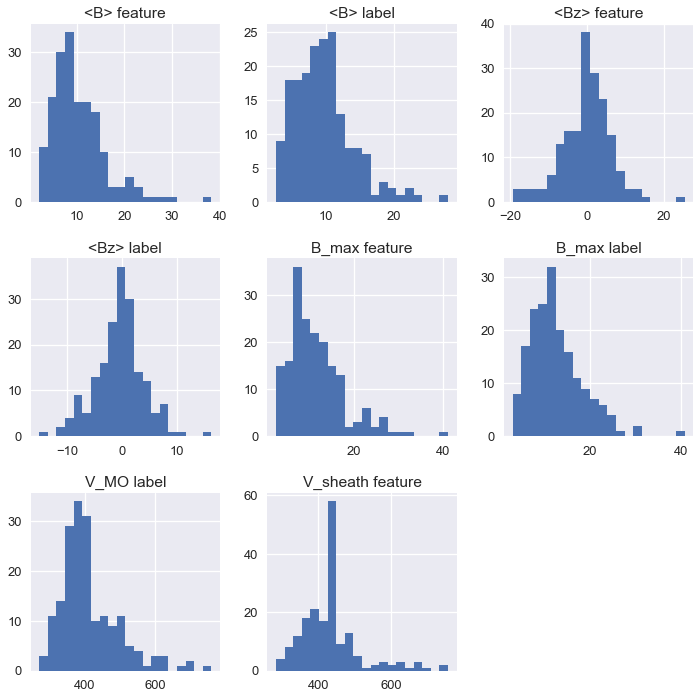

In [15]:
######## Version (1)  - prediction of scalar labels with a linear model, start with Btot

###############  define features of first 6 hours


#get_features=True
get_features=False

if get_features:

		#first few hours of each MFR
		feature_hours=3

		print('extract features and labels')
		print('feature_hours is: ',feature_hours)

		bzmeanfeature=np.zeros(np.size(iwinind))
		bzmeanlabel=np.zeros(np.size(iwinind))

		btotmeanfeature=np.zeros(np.size(iwinind))
		btotmeanlabel=np.zeros(np.size(iwinind))
		
		btotmaxfeature=np.zeros(np.size(iwinind))
		btotmaxlabel=np.zeros(np.size(iwinind))

		#derive features and labels
		for p in np.arange(np.size(iwinind)):

						#extract values from MFR data   for first feature_hours
						feature_bz=win.bz[np.where(np.logical_and(win_time > mo_start_time_num[iwinind[0][p]],
																																														win_time < mo_start_time_num[iwinind[0][p]]+feature_hours/24.0) )] 
						bzmeanfeature[p]=np.nanmean(feature_bz)
				
						feature_btot=win.btot[np.where(np.logical_and(win_time > mo_start_time_num[iwinind[0][p]],
																																														win_time < mo_start_time_num[iwinind[0][p]]+feature_hours/24.0) )] 
						btotmeanfeature[p]=np.nanmean(feature_btot)
						btotmaxfeature[p]=np.nanmax(feature_btot)


						#time is extracted from feature_hours to end of MFR
						label_bz=win.bz[np.where(np.logical_and(win_time > mo_start_time_num[iwinind[0][p]]+feature_hours/24.0,
																																														win_time < mo_end_time_num[iwinind[0][p]]))] 
						bzmeanlabel[p]=np.nanmean(label_bz)

						label_btot=win.btot[np.where(np.logical_and(win_time > mo_start_time_num[iwinind[0][p]]+feature_hours/24.0,
																																														win_time < mo_end_time_num[iwinind[0][p]]))] 
						btotmeanlabel[p]=np.nanmean(label_btot)
						btotmaxlabel[p]=np.nanmax(label_btot)
						
						


		#correct nans with mean of array
		nans=np.where(np.isnan(bzmeanlabel) == True)
		bzmeanlabel[nans]=np.nanmean(bzmeanlabel)

		nans=np.where(np.isnan(btotmeanlabel) == True)
		btotmeanlabel[nans]=np.nanmean(btotmeanlabel)

		nans=np.where(np.isnan(bzmeanfeature) == True)
		bzmeanfeature[nans]=np.nanmean(bzmeanfeature)

		nans=np.where(np.isnan(btotmeanfeature) == True)
		btotmeanfeature[nans]=np.nanmean(btotmeanfeature)
		
		#crazy error in pandas - > convert because of endian issue	
		#https://pandas-docs.github.io/pandas-docs-travis/gotchas.html
		v_mo=mo_speed[iwinind].byteswap().newbyteorder() 

		v_sheath=sheath_speed[iwinind].byteswap().newbyteorder() 
		
		nans=np.where(np.isnan(v_sheath) == True)
		v_sheath[nans]=np.nanmean(v_sheath)

		

		#fl feature labels 
		fl = {'<Bz> feature': bzmeanfeature, '<Bz> label': bzmeanlabel, '<B> feature': btotmeanfeature,  '<B> label': btotmeanlabel,'B_max feature': btotmaxfeature,  'B_max label': btotmaxlabel, 'V_MO label':v_mo,'V_sheath feature':v_sheath}

		#fl frame
		flf = pd.DataFrame(data=fl)
		print(flf.describe())

		#features 
		#convert to correct format
		#X=btotmeanfeature
		#X=X.reshape(-1,1)
		#labels
		X=flf['<B> feature'] #reshape for sklearn later
		y=flf['<B> label']
		
		Xm=flf['B_max feature'] #reshape for sklearn
		ym=flf['B_max label']
		
		Xv=flf['V_sheath feature'] #reshape for sklearn
		yv=flf['V_MO label']


		#save extracted features and labels
#	pickle.dump([btotmeanfeature, btotmeanlabel,bzmeanfeature,bzmeanlabel,btotmaxlabel,btotmaxfeature,X,y,Xm,ym,flf], open( "mfr_features_labels_save.p", "wb" ) ) 
		pickle.dump([flf,X,y,Xm,ym, Xv,yv], open( "mfr_predict/mfr_features_labels_save.p", "wb" ) ) 

		print('saved features and labels')

#######################################################################################
if get_features== False:
    [flf,X,y,Xm,ym,Xv,yv]= pickle.load( open( "mfr_predict/mfr_features_labels_save.p", "rb" ) )


############ All data

#check data histograms
flf.hist(bins=20,figsize=(10,10))
plt.tight_layout()
filename='mfr_predict/hist.png'
plt.savefig(filename)

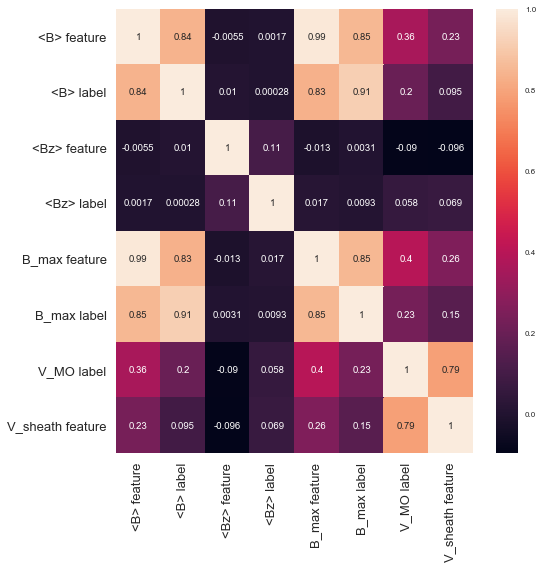

In [16]:
#correlation map
fig, ax = plt.subplots(1,figsize=(8,8))
corrmat=flf.corr()
sns.set(font_scale=0.8)
sns.heatmap(corrmat, annot=True, ax=ax)
plt.tight_layout()

filename='mfr_predict/corr.png'
plt.savefig(filename)

Scores for <Btot>: mean absolute error, mean squared, median absolute, R2: Btot in nT
1.505403324979826
4.545748695733014
1.0734346335034122
0.7434582429133454
y =  2.663181927652225  + X *  0.6642658363959405
Example for prediction of average Btot - linear model trained, new value observed 10,15,20 nT:
[9.30584029]
[12.62716947]
[15.94849866]


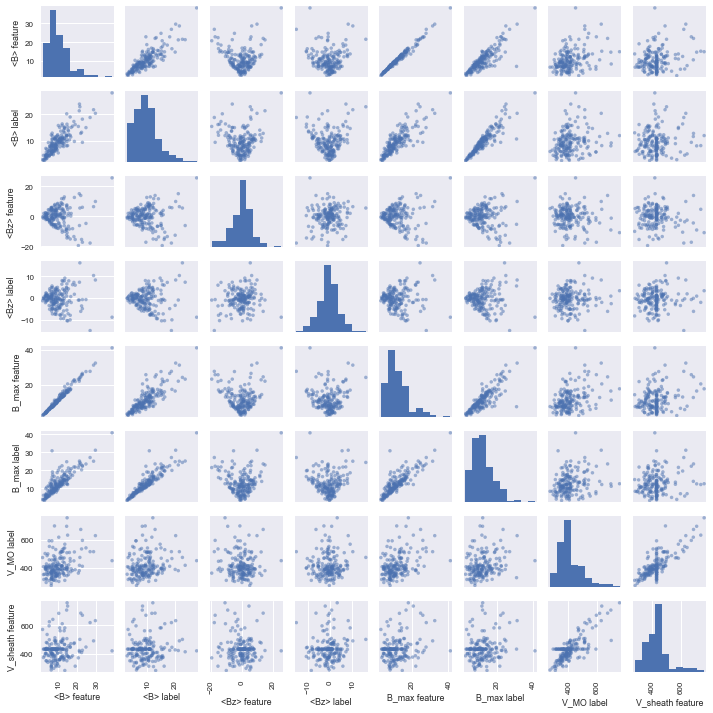

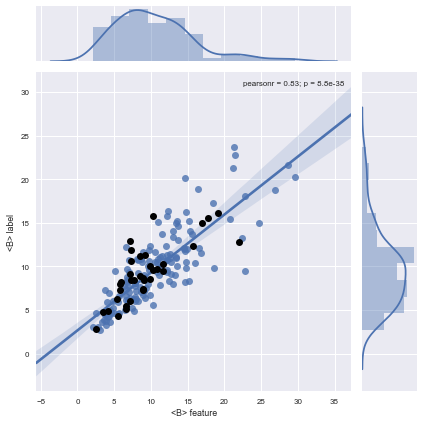

In [17]:
pd.plotting.scatter_matrix(flf,figsize=(10,10))
plt.tight_layout()
filename='mfr_predict/scatter_matrix.png'
plt.savefig(filename)

############### Btot average




#split into training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

##linear model
import sklearn.linear_model as lm
lr=lm.LinearRegression()
lr.fit(np.array(X_train).reshape(-1,1),y_train) #format needs to be different for lr.fit...
y_pred = lr.predict(np.array(X_test).reshape(-1,1))

#print('R**2 score linear fit')
#print(lr.score(X,y))

from sklearn.metrics import  mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
print('Scores for <Btot>: mean absolute error, mean squared, median absolute, R2: Btot in nT')
print(mean_absolute_error(y_pred,y_test))
print(mean_squared_error(y_pred,y_test))
print(median_absolute_error(y_pred,y_test))
print(r2_score(y_pred,y_test))


#these are the fit coefficients
print('y = ',lr.intercept_,' + X * ',lr.coef_[0])

sns.jointplot(X_train,y_train,kind='reg')
plt.plot(X_test,y_test,'ko')

#plt.figure(3)
#plt.plot(X,y_pred,'k-')
#plt.plot(X, lr.intercept_+X*lr.coef_,'g-')



print('Example for prediction of average Btot - linear model trained, new value observed 10,15,20 nT:')
print(lr.predict(10))
print(lr.predict(15))
print(lr.predict(20))

filename='mfr_predict/bmean.png'
plt.savefig(filename)

linear model for Bmax
y =  3.1485981203134514  + X *  0.8004837478215922


Example for prediction of Bmax - linear model trained, new value observed 10,15,20 nT:
[11.1534356]
[15.15585434]
[19.15827308]
Scores for Bmax: mean absolute error, mean squared, median absolute, R2: Btot in nT
2.4512728070150245
13.332994944438948
1.104424848347465
0.48184564487761994
linear model for Bmax
y =  59.87743162478387  + X *  0.8199135639228132


Example for prediction of V_MO - linear model trained, new value observed 400, 600, 800 km/s:
[387.84285719]
[551.82556998]
[715.80828276]
Scores for V_MO: mean absolute error, mean squared, median absolute, R2: V_MO in km/s
70.23953482102553
6753.617760723446
63.65973154571316
-1.5889290442650408


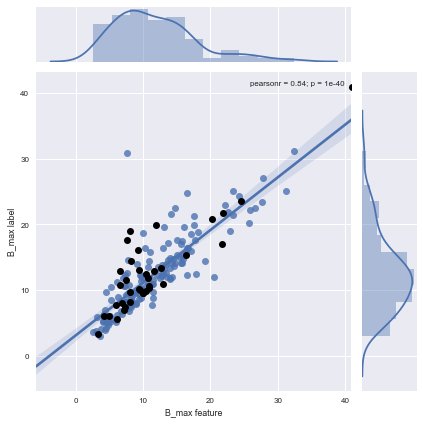

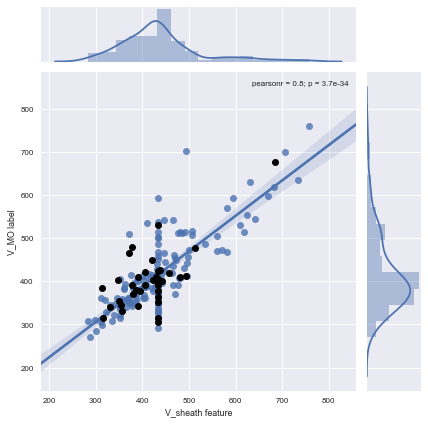

In [18]:
########### ##linear model for Bmax

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2, random_state=8)

import sklearn.linear_model as lm
lrm=lm.LinearRegression()
lrm.fit(np.array(Xm_train).reshape(-1,1),ym_train)
print('linear model for Bmax')
print('y = ',lrm.intercept_,' + X * ',lrm.coef_[0])
#print(lr.score(Xm,ym))

ym_pred = lrm.predict(np.array(X_test).reshape(-1,1))


print()
print()

print('Example for prediction of Bmax - linear model trained, new value observed 10,15,20 nT:')
print(lrm.predict(10))
print(lrm.predict(15))
print(lrm.predict(20))

print('Scores for Bmax: mean absolute error, mean squared, median absolute, R2: Btot in nT')
print(mean_absolute_error(ym_pred,ym_test))
print(mean_squared_error(ym_pred,ym_test))
print(median_absolute_error(ym_pred,ym_test))
print(r2_score(ym_pred,ym_test))

sns.jointplot(Xm_train,ym_train,kind='reg')
plt.plot(Xm_test,ym_test,'ko')

filename='mfr_predict/bmax.png'
plt.savefig(filename)





########### ##linear model for V_MO aus V_sheath

Xv_train, Xv_test, yv_train, yv_test = train_test_split(Xv, yv, test_size=0.2, random_state=8)

import sklearn.linear_model as lm
lrv=lm.LinearRegression()
lrv.fit(np.array(Xv_train).reshape(-1,1),yv_train)
print('linear model for Bmax')
print('y = ',lrv.intercept_,' + X * ',lrv.coef_[0])
#print(lr.score(Xm,ym))

yv_pred = lrm.predict(np.array(Xv_test).reshape(-1,1))


print()
print()

print('Example for prediction of V_MO - linear model trained, new value observed 400, 600, 800 km/s:')
print(lrv.predict(400))
print(lrv.predict(600))
print(lrv.predict(800))

print('Scores for V_MO: mean absolute error, mean squared, median absolute, R2: V_MO in km/s')
print(mean_absolute_error(yv_pred,yv_test))
print(mean_squared_error(yv_pred,yv_test))
print(median_absolute_error(yv_pred,yv_test))
print(r2_score(yv_pred,yv_test))

sns.jointplot(Xv_train,yv_train,kind='reg')
plt.plot(Xv_test,yv_test,'ko')

filename='mfr_predict/vmo.png'
plt.savefig(filename)